<a href="https://colab.research.google.com/github/bhomaidan1990/Computer_Vision_Labs/blob/main/CV_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Course
## Lab 3 Pyramids

In [ ]:
##########################
# @Authors:              #
#     Belal Hmedan       #
# &   Junyi ZHONG        #
##########################
#
#========================
# Import Libraries
#========================
import os
import glob
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Rectangle
from keras.preprocessing import image
import cv2
import time
import re
from math import sqrt, ceil, floor, sin, pi
import keras 
import tensorflow as tf
from keras import layers
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
#--------------------------------------------
from skimage import exposure as exposure
from sklearn.metrics import roc_curve

#### Reproducible Code Initialization

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
# tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
# Comment This part if you are Working Online on Google Colab
#========================
# Paths Initialization
#========================
# Define the Path of the original FDDB, and the output path
outPath     = "H:/2_Computer_vision/Datasets/Pyramid_DS"
# Specify The required path
foldsPath = "H:/2_Computer_vision/Datasets/FDDB_Dataset/FDDB-folds/"
FDDB_path  = "H:/2_Computer_vision/Datasets/FDDB_Dataset/Datast/"
datasetPath = FDDB_path

### Q1: Scale-invariant Gaussian pyramid

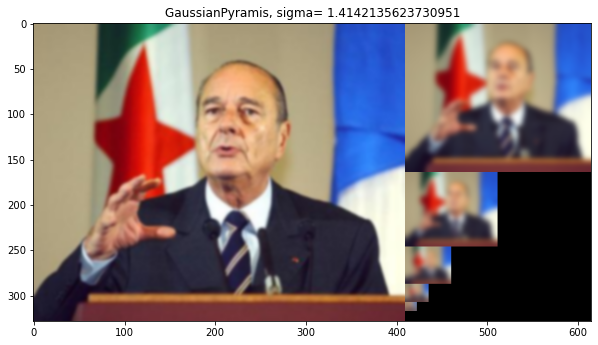

In [ ]:
#=================
# Resize Function
#=================   
def _resize(image, step=0.5, minSize=(16, 16)):
    if(image.shape > minSize ):
        # newSize = (image.shape[0]// downscale, image.shape[1]//downscale)
        newImage = cv2.resize(image, None, fx=step, fy=step) 
        return newImage
    else:
        return 0
#===========================
# Gaussian Pyramid Function
#===========================
def pyramid(image, sigma_0=1):
    '''
    Function to create a Gaussian pyramid from an image for given standard deviation sigma_0

    Parameters:
    -----------
    @param: image: nd-array.
             The original image.
    @param: sigma_0: float.
            standard deviation of the Gaussian distribution.

    returns:
    List of images with different scales, the pyramid
    '''
    # level 0
    if ceil(6*sigma_0)%2 ==0 : 
        Gimage = cv2.GaussianBlur(image, (ceil(6*sigma_0)+1, ceil(6*sigma_0)+1), sigmaX=sigma_0, sigmaY=sigma_0)
    else:
        Gimage = cv2.GaussianBlur(image, (ceil(6*sigma_0)+2, ceil(6*sigma_0)+2), sigmaX=sigma_0, sigmaY=sigma_0)
    # sigma_k
    sigma_k = 4*sigma_0
    # sigma_k = sqrt(2)*sigma_0

    # Pyramid as list
    GaussPyr = [Gimage]
    k = 1
    # Loop  of other levels of the pyramid
    while(isinstance(_resize(GaussPyr[k-1]), np.ndarray)):

        if ceil(6*sigma_k)%2 ==0 :
            smoothed = cv2.GaussianBlur(GaussPyr[k-1], (ceil(6*sigma_k)+1, ceil(6*sigma_k)+1), sigmaX=sigma_k, sigmaY=sigma_k)
        else:
            smoothed = cv2.GaussianBlur(GaussPyr[k-1], (ceil(6*sigma_k)+2, ceil(6*sigma_k)+2), sigmaX=sigma_k, sigmaY=sigma_k)

        # Downscaled Image
        resized = _resize(smoothed) 
        GaussPyr.append(resized)
        k += 1
    return GaussPyr
#--------------------------------------------------------------
# Read Image
#=============
img = cv2.imread("H:/2_Computer_vision/Datasets/FDDB_Dataset/Datast/2003/03/03/big/img_907.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# sigma
sigma = sqrt(2)

# Create a Gaussian pyramid
pyr1 = pyramid(img, sigma_0=sigma)

# Visualizse the Pyramid
# Pyramid dimensions
rows = pyr1[0].shape[0]
cols = int(1.5*pyr1[0].shape[1])
# pyramid container
container = np.zeros((rows, cols, 3), dtype=int)
oldrows = 0
container[:pyr1[0].shape[0], :pyr1[0].shape[1], :] = pyr1[0]

for idx, im in enumerate(pyr1):
    if idx != 0 :
        nrows, ncols = pyr1[idx].shape[0], pyr1[idx].shape[1]
        # print(oldrows, nrows, ncols , container[oldrows:oldrows+nrows, 512:512+ncols,:].shape)
        container[oldrows:oldrows+nrows, pyr1[0].shape[1]:pyr1[0].shape[1]+ncols,:] = pyr1[idx]
        oldrows += nrows
#====================
# Visualize Results
#====================
plt.figure(num="Pyramids", figsize=(10,10))
plt.imshow(container)
plt.title("GaussianPyramis, sigma= {}".format(sigma))
plt.show()

#### Pyramid Impulse Response

Impulse Response

In [ ]:
#====================
# Impulse Response
#====================
# Zeros 512x512 Black Image
delta = np.zeros((512, 512), dtype=np.float32)
# Dirac
delta[255,255] = 255

# sigmas
sigma1 = 1
sigma2 = sqrt(2)

# Pyramids
deltaPyramid1 = pyramid(delta, sigma_0=sigma1)
deltaPyramid2 = pyramid(delta, sigma_0=sigma2)

# Impulse Response for each level
ImpResp1 = np.zeros((len(deltaPyramid1), 13),dtype=float)
ImpResp2 = np.zeros((len(deltaPyramid2), 13),dtype=float)
# sigma = 1
for idx, level in enumerate(deltaPyramid1):
    centery = level.shape[0]//2
    centerx = level.shape[1]//2
    ImpResp1[idx,:] = exposure.rescale_intensity(level[centery, (centerx-7):(centerx+6)], out_range=(0,255), in_range='image').astype(np.uint8)

# sigma = sqrt(2)
for idx, level in enumerate(deltaPyramid2):
    centery = level.shape[0]//2
    centerx = level.shape[1]//2
    ImpResp2[idx,:] = exposure.rescale_intensity(level[centery, (centerx-7):(centerx+6)], out_range=(0,255), in_range='image').astype(np.uint8)


#### Visualize Impulse Response

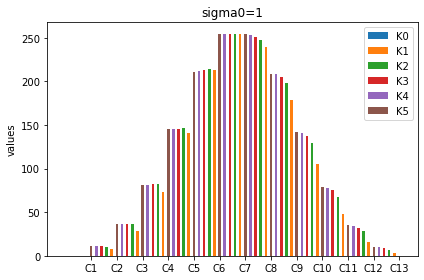

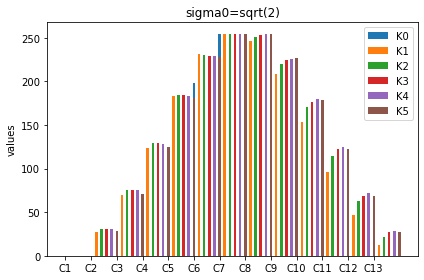

In [ ]:
#====================
# Visualize Results
#====================
labels = []
for c in range(13):
    label = 'C{}'.format(c+1)
    labels.append(label)

x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = []
for k in range(ImpResp1.shape[0]):
    rects1.append(ax.bar(x - 2*k*width, ImpResp1[k], width, label='K{}'.format(k)))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('values')
ax.set_title('sigma0=1')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

fig2, ax2 = plt.subplots()
rects2 = []
for k in range(ImpResp1.shape[0]):
    rects2.append(ax2.bar(x + 2*k*width, ImpResp2[k], width, label='K{}'.format(k)))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('values')
ax2.set_title('sigma0=sqrt(2)')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()

fig2.tight_layout()

plt.show()

#### Comparision
The Pyramid is scale invariant for any $\sigma_0$, but smoothing and kernel size are related to the $\sigma_0$, and the results seems to be a little better with $\sigma_0 = \sqrt 2$.

**Generally:**
If $\sigma_0$ is the initial smoothing, and $\sigma_1$ is the smoothing applied before downscaling, and downscaling is by a factor $\Delta S > 1 $, then this relationship:
$\frac{\sqrt{(\sigma_0^{2} + \sigma_1^{2})}}{\Delta S} \approx \sigma_0$
will ensure that the downscaled image is the same as the original smoothed image (up to intensity scaling). We obtain:
$\sigma_1 = \sqrt{((\sigma_0 * \Delta S)^2 - \sigma_0^{2})}$

[**Reference**](https://stackoverflow.com/questions/64712555/how-to-demonstrate-that-the-impulse-response-of-the-gaussian-pyramid-is-scale-in/64729002#64729002)

### Q2: MLP for Face Detection

In [ ]:
#=======================
foldsList  = os.listdir(foldsPath)
foldsList.sort()
folds = foldsList[1::2] # Evens, image names
annot = foldsList[0::2] # Odds, annotaions
# print(folds, '\n \n ', annot)

#========================
# Get Annotation Function
#========================
def getAnnot(imgName, annotPath):
    '''
    Function to get the annotations in nd-array format for a specified image.
    
    Parameters:
    @Param: imgName : the specified image path(inside the DB).
    @Param: annotPath : the path to the txt file where the annotations stored.
    
    returns: nd-array with shape m x 5, : m num of the detected faces in the image.
             (5): max_radius | min_radius | angle | center_x | center_y
    '''
    # Initialization
    Annotaions = []
    AnnotData = []
    linIndex = -2
    numFaces = 0
 
    # Annot Search Loop
    AnnotFile = open(annotPath, "r")
    for idx, lin in enumerate(AnnotFile):
        if(re.findall(imgName,lin) != []):
            linIndex = idx
            # print(imgName, idx)
        if (idx == (linIndex + 1) ):
            numFaces = int(lin)
            # print("number of faces is: ", numFaces)
        if linIndex != -2:
            if idx in range(linIndex + 2, linIndex + 2 + numFaces):
                Annotaions.append(lin)
    # print(Annotaions)
    for Annotaion in Annotaions:
        AnnotData.append(list(filter(None, list(re.split("\s", Annotaion)))))
    AnnotData = np.array(AnnotData, dtype=float )
    AnnotData = AnnotData[...,:-1]
    # Close the txt file
    AnnotFile.close()
 
    return AnnotData

In [ ]:
#============================
# Annots Ellipse 2 Rectancle
#============================
def ellip2rect(AnnArr):
    ResArr = np.zeros_like(AnnArr)
    for row in range(AnnArr.shape[0]):
        Rmax = AnnArr[row, 0]
        Rmin = AnnArr[row, 1]
        theta = AnnArr[row, 2]
        xc = AnnArr[row, 3]
        yc = AnnArr[row, 4]

        # Rectangle Borders 
        st = sin(theta)
        st = st if st > 0 else -st
        if(st == 0):
            st = 1
        # represents the top left corner of rectangle 
        x0 = floor(xc - Rmin * st)
        x0 = x0 if x0 > 0 else 0
        y0 = floor(yc - Rmax *st)
        y0 = y0 if y0 > 0 else 0
        # represents the bottom right corner of rectangle 
        x1 = floor(xc + Rmin * st)
        y1 = floor(yc + Rmax * st)
        ResArr[row] = [x0, y0, x1, y1, 0]
    ResArr = ResArr[:,:-1].astype(int)
    return ResArr

In [ ]:
#------------------------
# Build Data structure for easy indexing
# Dict[key = fold_num, value = dict[key = image name, value = nd-array]]
#========================================
DS = {}
for idx, fold in enumerate(folds[-2:]):
    # print(fold)
    foldPath = os.path.join(foldsPath, fold)
    txtFile = open(foldPath, "r")
    imgDict = {}
    for lin in txtFile:
        imName = lin[:-1]
        # this to find only the string which ends with ths pattern
        imName = imName + '$'
        annotDir = os.path.join(foldsPath,annot[8+idx])
        # print(annot[8+idx])
        # print("There",imName, annotDir)
        imgDict[lin[:-1]] = ellip2rect(getAnnot(imName,annotDir))
        # print(imgList[0])
    # Close the txt file
    txtFile.close()
    DS["fold_{}".format(str(idx+9))] = imgDict
    
#==================
# IOU function 
#==================
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    # iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    # New Criteria 
    iou = interArea / float(boxAArea)
    return iou

def IOU(fold, imagePath, SW_x0, SW_y0, windowSize, level):
    # Sliding Window corner
    SW_x1 = SW_x0 + windowSize
    SW_y1 = SW_y0 + windowSize
    SW = [SW_x0, SW_y0, SW_x1, SW_y1]
    IOU_Value = 0.0
    # get the annotations for each imagePath
    # devide the annotaions by (2**idx)
    Anns = DS[fold][imagePath] # max_radius | min_radius | angle | center_x | center_y
    Annots = Anns.copy()
    Annots = (0.5**level) * Annots
    Annots = Annots.astype(int)
    # Loop Faces
    for row in range(Annots.shape[0]):
        # Get the most promising face
        IOU_Value = max(IOU_Value, bb_intersection_over_union(Annots[row], SW))
    return IOU_Value
#==================
# Sliding Window
#==================
def sliding_window_extractor(fold, imagePath, extPath, windowSize, SF):
    # Initialization
    global index
    fullImagePath = os.path.join(datasetPath, imagePath + '.jpg').replace('\\','/')
    original = cv2.imread(fullImagePath)
    imagePyarmid = pyramid(original)
    # Loop Pyramid Levels
    for level, image in enumerate(imagePyarmid):
        # check sliding window size
        if image.shape > (windowSize, windowSize):
            # Loop image
            nrows = 0
            while((nrows + windowSize) < image.shape[0]):
                ncols = 0
                stepSize = windowSize//2
                while((ncols+windowSize)< image.shape[1]):
                    window = image[nrows:nrows+ windowSize, ncols:ncols+windowSize, :]
                    # print(nrows, ncols, image.shape, windowSize)
                    # Check IOU for GT
                    overlap = IOU(fold, imagePath, ncols, nrows, windowSize, level)
                    if overlap > 0.5:
                        cv2.imwrite(os.path.join(extPath,"face", "face_{}_{}_{}.jpg".format(windowSize, level, index)),window)
                        index +=1
                    else:
                        cv2.imwrite(os.path.join(extPath, "background","background_{}_{}_{}.jpg".format(windowSize, level, index)),window)
                        index +=1
                    # Update indicies
                    ncols += stepSize
                # Update indicies
                nrows += windowSize//2
                windowSize = int(windowSize*(SF**idx))
                

In [ ]:
# Sliding Window Initilaization
scales = [1.2, 1.4, 1.6, 1.8, 2]
index = 0
# set a timer:
tic2 = time.time()
# Loop Sizes
for Scale in scales:
    # set a timer:
    tic1 = time.time()
    # make dirs for each size
    myDir = os.path.join(outPath, str(int(10*Scale)))
    myFace = os.path.join(myDir, 'face')
    myBackground = os.path.join(myDir, 'background')
    if(not os.path.isdir(myDir)):
        os.mkdir(myDir)
        os.mkdir(myFace)
        os.mkdir(myBackground)
    # initialize
    windowSize = 16
    # Looping Folds 9, 10
    for fold in DS:
        for imPath in DS[fold]:
            sliding_window_extractor(fold,imPath, myDir, windowSize, Scale)
    toc1 = time.time()
    print("Time for sclae{} is:".format(Scale), toc1 - tic1)
toc2 = time.time()
print("Total time is: ", toc2 - tic2)

Time for sclae1.2 is: 369.0440835952759
Time for sclae1.4 is: 225.907329082489
Time for sclae1.6 is: 175.2080910205841
Time for sclae1.8 is: 149.55756878852844
Time for sclae2 is: 131.8054506778717
Total time is:  1051.5232665538788


### Metrics

In [ ]:
def precision_func(TP, FP):
    return (TP/(TP+FP))

def recall_func(TP, FN):
    return(TP/(TP+FN))

def accuracy_func(y_pred, y_label):
    return ((y_label.shape - np.sum(np.bitwise_xor(y_label, y_pred))) / y_label.shape).item()

def F1_Score_func(Precision, Recall):
    return (2*Precision*Recall)/(Precision+Recall)

def perf_measure(y_pred, y_label):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_label[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_label[i]!=y_pred[i]:
           FP += 1
        if y_label[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_label[i]!=y_pred[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [ ]:
# Define Window size (color images)
img_window = (32,32,3)
# Input shape = Window shape flattened
input_shape = np.prod(img_window)
#=====================
# Model Architecture
#=====================
simpleMLP = Sequential(
    [layers.InputLayer(input_shape=img_window, name ="InputLayer"),
     layers.Flatten(name ="FlattenLayer"), # Flattens the input, conv2D to 1 vector , which does not affect the batch size.
     layers.Dense(input_shape //2, activation="relu", name ="HLayer1"),
     #  layers.Dropout(0.2),
     layers.Dense(input_shape //2, activation="relu", name ="HLayer2"),
     #  layers.Dropout(0.1),
     layers.Dense(input_shape //2, activation="relu", name ="HLayer3"),
     #  layers.Dropout(0.1),
     layers.Dense(1,activation="sigmoid", name ="OutputLayer"),
     ])
#---------------------------------------------------------------------
# Compile the Model
#===================
# Adaptitve Learning Rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,
    decay_rate=0.9)
#----------------------------------------------------
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
# Compile MLP model with 3 arguments: loss function, optimizer, and metrics function to judge model performance
simpleMLP.compile(loss="binary_crossentropy",optimizer= optimizer,metrics=["binary_accuracy"]) 

#================
# Load the Model
#================
# Linux Version
# simpleMLP.load_weights('/media/desertghost/WD/2_Computer_vision/Lecture_2/Lab_2/MLPmodel_Best94.h5')
# Winsows Version:
simpleMLP.load_weights('H:/2_Computer_vision/Lecture_2/Lab_2/MLPmodel_Beste-3.h5')
# Check if GPU Available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"]="0"
    print('GPU is available')
    tf.config.list_physical_devices('GPU')

GPU is available


In [ ]:
# Create ImagedataGenerator 
#==========================
batch_size = 64
# Path
# Linux version
# testPath = '/media/desertghost/WD/2_Computer_vision/Datasets/Pyramid_DS'
# Windows version
testPath = 'H:/2_Computer_vision/Datasets/Pyramid_DS'
testScales = os.listdir(testPath)
testScales.sort()
# Metrics
Metrics = []
# Loop Scales
for scale in testScales:
    #---------------------
    # Test Data Generator
    #---------------------
    test_dir = os.path.join(testPath, scale)
    test_datagen = ImageDataGenerator(rescale=1./255) # 
    #
    test_generator_eval = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_window[:2],
        batch_size=batch_size,
        class_mode='binary',
        color_mode='rgb',
        shuffle=False
        )
    #================
    # Predict Model
    #================
    prediction = simpleMLP.predict(test_generator_eval)
    #-----------------------------------------
    fpr, tpr, thresholds  = roc_curve(test_generator_eval.classes, prediction)
    # Threshold Prediction
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    prediction[prediction< optimal_threshold] = 0
    prediction[prediction>= optimal_threshold] = 1
    prediction = (prediction.ravel()).astype(int)
    # Get Y_GroundTruth
    y_label = (np.expand_dims(test_generator_eval.classes, axis=1).ravel()).astype(int)

    # Get Metrics
    # Metrics = precision_recall_fscore_support(y_True, prediction)
    # ----------------------------
    Accuracy = accuracy_func(prediction, y_label)

    (tp, fp, tn, fn) = perf_measure(prediction, y_label)
    # Precision = np.min(Metrics[0])
    Precision = precision_func(tp, fp)

    # Recall = np.min(Metrics[1])
    Recall = recall_func(tp, fn)

    F1_Score = F1_Score_func(Precision, Recall)
    metric = [Accuracy ,Precision, Recall, F1_Score]
    print(metric)
    Metrics.append(metric)
# Free GPU Memory
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

Found 137269 images belonging to 2 classes.
[0.8540602758088134, 0.024514501891551074, 0.411864406779661, 0.04627469650083314]
Found 79519 images belonging to 2 classes.
[0.874004954790679, 0.03645200486026731, 0.4171494785631518, 0.06704534872893193]
Found 61387 images belonging to 2 classes.
[0.9201459592421848, 0.09379070777247069, 0.3724137931034483, 0.14984391259105098]
Found 51689 images belonging to 2 classes.
[0.9112383679312813, 0.11455399061032864, 0.37423312883435583, 0.17541337167505394]
Found 45690 images belonging to 2 classes.
[0.9055810899540381, 0.12269628881595557, 0.3667924528301887, 0.18388195232690124]


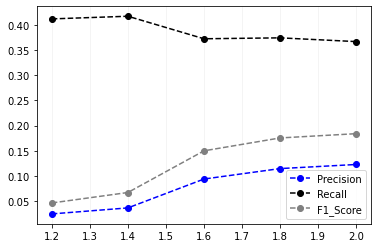

In [ ]:
x = [1.2, 1.4, 1.6, 1.8, 2]
y = np.array(Metrics, dtype=float)

# plt.plot(x, y[:,0], 'o--', color='green', label='Accuracy')

plt.plot(x, y[:,1], 'o--', color='blue', label='Precision')

plt.plot(x, y[:,2], 'o--', color='black', label='Recall')

plt.plot(x, y[:,3], 'o--', color='grey', label='F1_Score')

plt.grid(axis='x', color='0.95')
plt.legend()
plt.show()

1. Recall is way higher that Precesion, which means the False Negatives are way less than the False Positives.
2. Precesion improves by increasing the scale factor, because the sliding window size increases, and thus overlapping between GT and the sliding window.
increasing the scale factor also increases the False Negatives.
3. Time needed to manipulate the data decreses by incresing scale factor, bigger sliding windows needs less time to sweep the entire image.

### Q3: MLP for Face Detection

In [ ]:
outPath2 = "H:/2_Computer_vision/Datasets/Pyramid_wins"
index = 0
# set a timer:
tic2 = time.time()
# Different window sizes
wins = [16, 19, 24, 32, 33]
# Loop Sizes
for win in wins:
    # set a timer:
    tic1 = time.time()
    # make dirs for each size
    myDir = os.path.join(outPath2, str(win))
    myFace = os.path.join(myDir, 'face')
    myBackground = os.path.join(myDir, 'background')
    if(not os.path.isdir(myDir)):
        os.mkdir(myDir)
        os.mkdir(myFace)
        os.mkdir(myBackground)
    # Looping Folds 9, 10
    for fold in DS:
        for imPath in DS[fold]:
            sliding_window_extractor(fold,imPath, myDir, win, 1.2)
    toc1 = time.time()
    print("Time for window{} is:".format(win), toc1 - tic1)
toc2 = time.time()
print("Total time is: ", toc2 - tic2)

Time for window16 is: 403.34152269363403
Time for window19 is: 339.33626890182495
Time for window24 is: 254.8778157234192
Time for window32 is: 186.1026165485382
Time for window33 is: 167.5658929347992
Total time is:  1351.2241168022156


In [ ]:
# Create ImagedataGenerator 
#==========================
batch_size = 64
# Path
# Linux version
# outPath2 = '/media/desertghost/WD/2_Computer_vision/Datasets/Pyramid_DS'
# Windows version
outPath2 = 'H:/2_Computer_vision/Datasets/Pyramid_wins'
testwins = os.listdir(outPath2)
testwins.sort()
# Metrics
Metrics = []
# Loop Scales
for win in testwins:
    #---------------------
    # Test Data Generator
    #---------------------
    test_dir = os.path.join(outPath2, win)
    test_datagen = ImageDataGenerator(rescale=1./255) # 
    #
    test_generator_eval = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_window[:2],
        batch_size=batch_size,
        class_mode='binary',
        color_mode='rgb',
        shuffle=False
        )
    #================
    # Predict Model
    #================
    prediction = simpleMLP.predict(test_generator_eval)
    #-----------------------------------------
    fpr, tpr, thresholds  = roc_curve(test_generator_eval.classes, prediction)
    # Threshold Prediction
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    prediction[prediction< optimal_threshold] = 0
    prediction[prediction>= optimal_threshold] = 1
    prediction = (prediction.ravel()).astype(int)
    # Get Y_GroundTruth
    y_label = (np.expand_dims(test_generator_eval.classes, axis=1).ravel()).astype(int)

    # Get Metrics
    # Metrics = precision_recall_fscore_support(y_True, prediction)
    # ----------------------------
    Accuracy = accuracy_func(prediction, y_label)

    (tp, fp, tn, fn) = perf_measure(prediction, y_label)
    # Precision = np.min(Metrics[0])
    Precision = precision_func(tp, fp)

    # Recall = np.min(Metrics[1])
    Recall = recall_func(tp, fn)

    F1_Score = F1_Score_func(Precision, Recall)
    metric = [Accuracy ,Precision, Recall, F1_Score]
    print(metric)
    Metrics.append(metric)
# Free GPU Memory
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

Found 137269 images belonging to 2 classes.
[0.8540602758088134, 0.024514501891551074, 0.411864406779661, 0.04627469650083314]
Found 112490 images belonging to 2 classes.
[0.827255756067206, 0.02738305155066902, 0.43781094527363185, 0.05154236626317845]
Found 84315 images belonging to 2 classes.
[0.8137460712803178, 0.034713724479938174, 0.4294820717131474, 0.06423549040638779]
Found 55774 images belonging to 2 classes.
[0.7861189801699717, 0.049496573314155176, 0.45703125, 0.08931979540422934]
Found 54488 images belonging to 2 classes.
[0.7618191161356629, 0.04988013301368804, 0.4824233358264772, 0.0904121110176619]


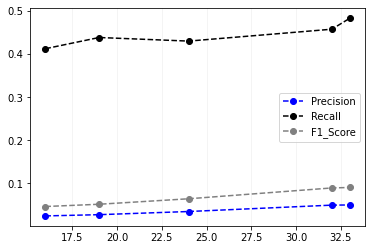

In [ ]:
x = [16, 19, 24, 32, 33]
y = np.array(Metrics, dtype=float)

# plt.plot(x, y[:,0], 'o--', color='green', label='Accuracy')

plt.plot(x, y[:,1], 'o--', color='blue', label='Precision')

plt.plot(x, y[:,2], 'o--', color='black', label='Recall')

plt.plot(x, y[:,3], 'o--', color='grey', label='F1_Score')

plt.grid(axis='x', color='0.95')
plt.legend()
plt.show()

1. Recall is high, precision is low, because we have many False positives.
2. The results seems to improve for bigger sliding window size.
3. Time consumption is decreasing for bigger window size.

In [ ]:
# Free GPU Memory
from numba import cuda
cuda.select_device(0)
cuda.close()